Summary of the top 2 models for PR:
                  Selection Method  Accuracy
0  SelectKBest_mutual_info_classif  0.904762
1            SelectKBest_f_classif  0.857143
Combined unique features used in the top 5 models for PR:
F1, F14, F28, F29, F43, F44, F45, Federal_Class, Provincial_Class
Accuracy in the top 5 models for PR:
0.8571428571428571
Summary of the top 2 models for NR:
                  Selection Method  Accuracy
0            SelectKBest_f_classif  0.809524
1  SelectKBest_mutual_info_classif  0.809524
Combined unique features used in the top 5 models for NR:
F43, F44, F45, F46
Accuracy in the top 5 models for NR:
0.7619047619047619
Summary of the top 2 models for SR:
                  Selection Method  Accuracy
0  SelectKBest_mutual_info_classif  0.809524
1  SelectKBest_mutual_info_classif  0.809524
Combined unique features used in the top 5 models for SR:
F1, F14, F24, F28, F29, F30, F31, F3_e, F41, F43, F44, F45, F46, Federal_Class, OF22, Provincial_Class
Accuracy in t

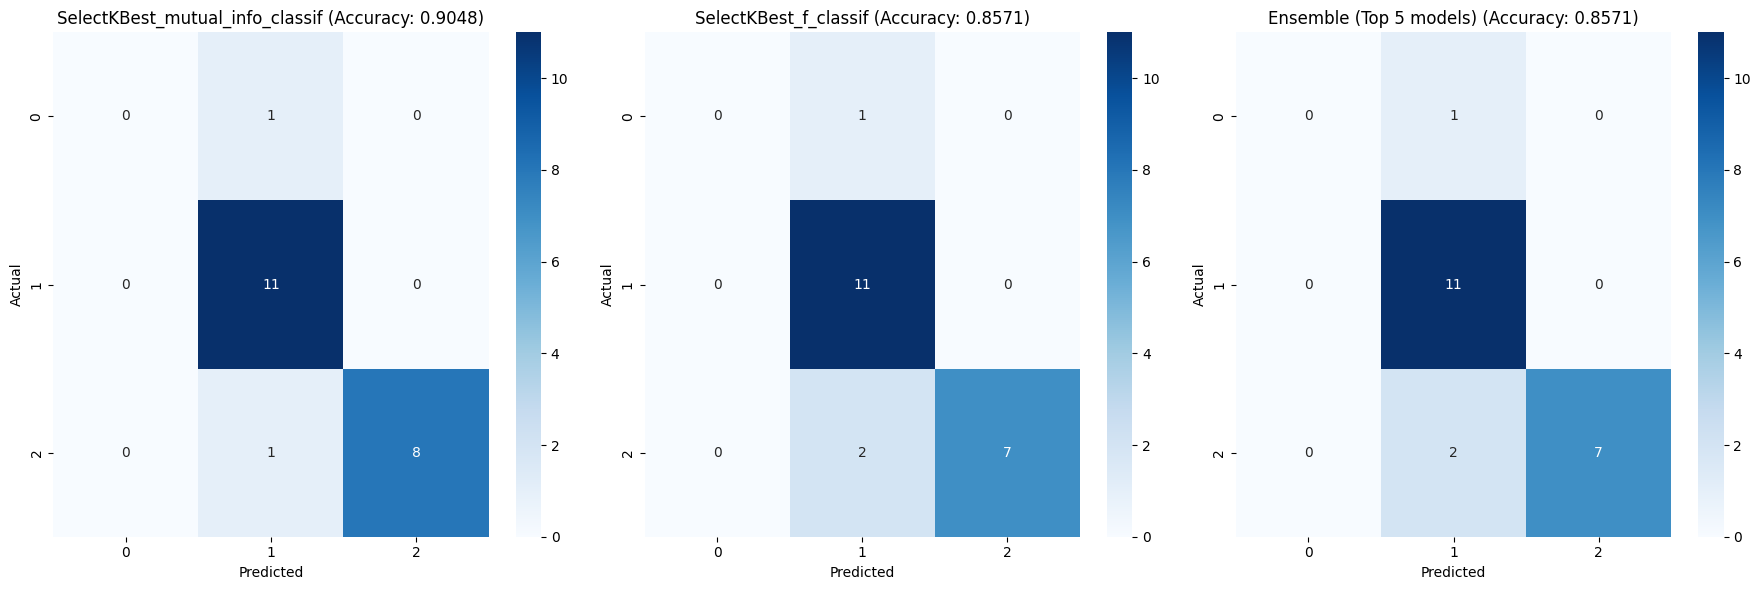

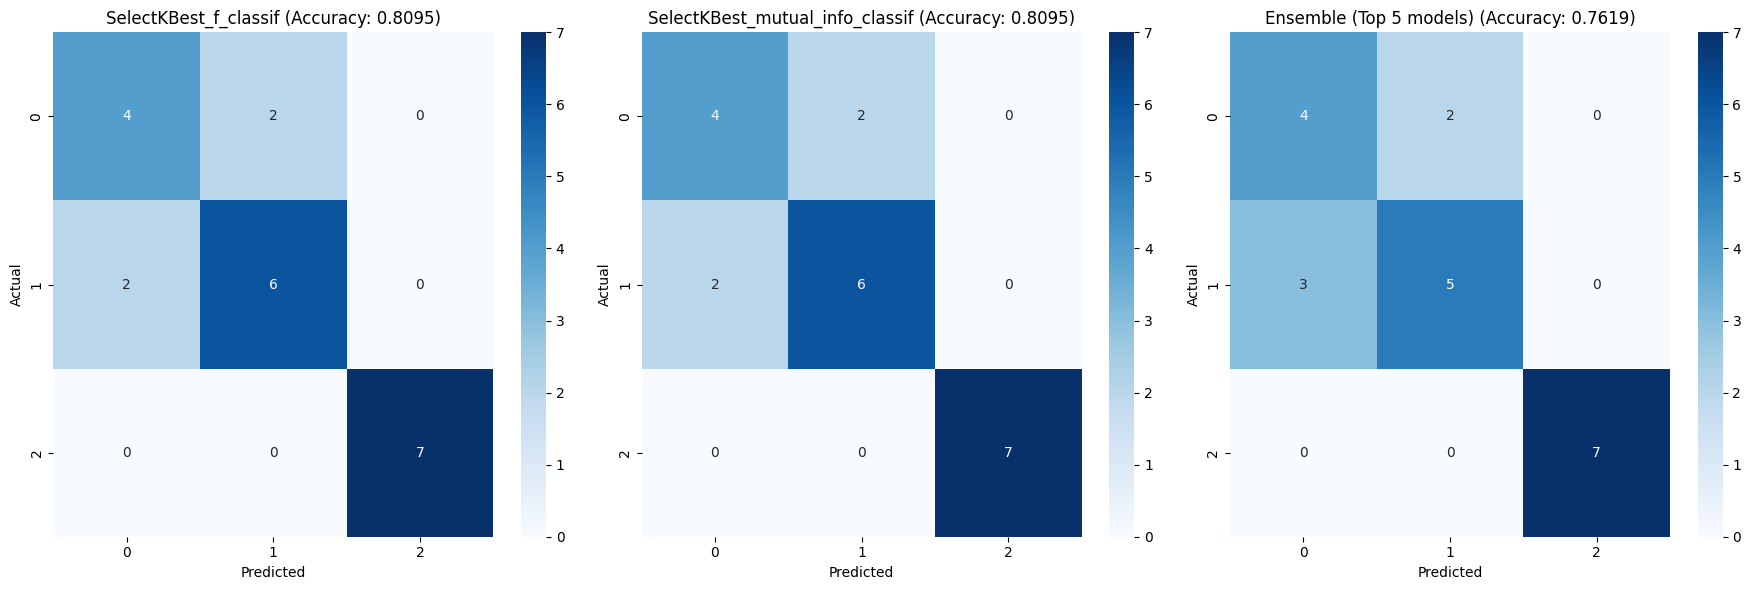

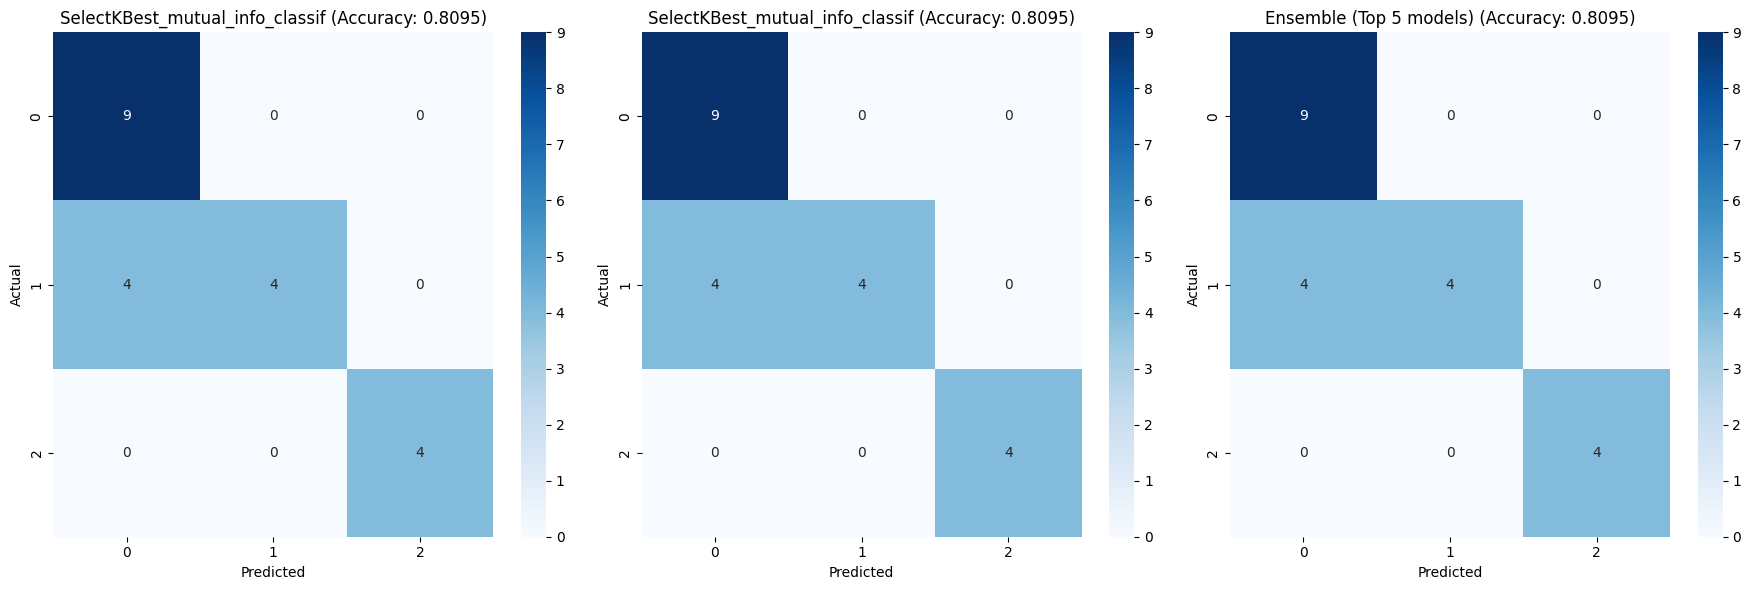

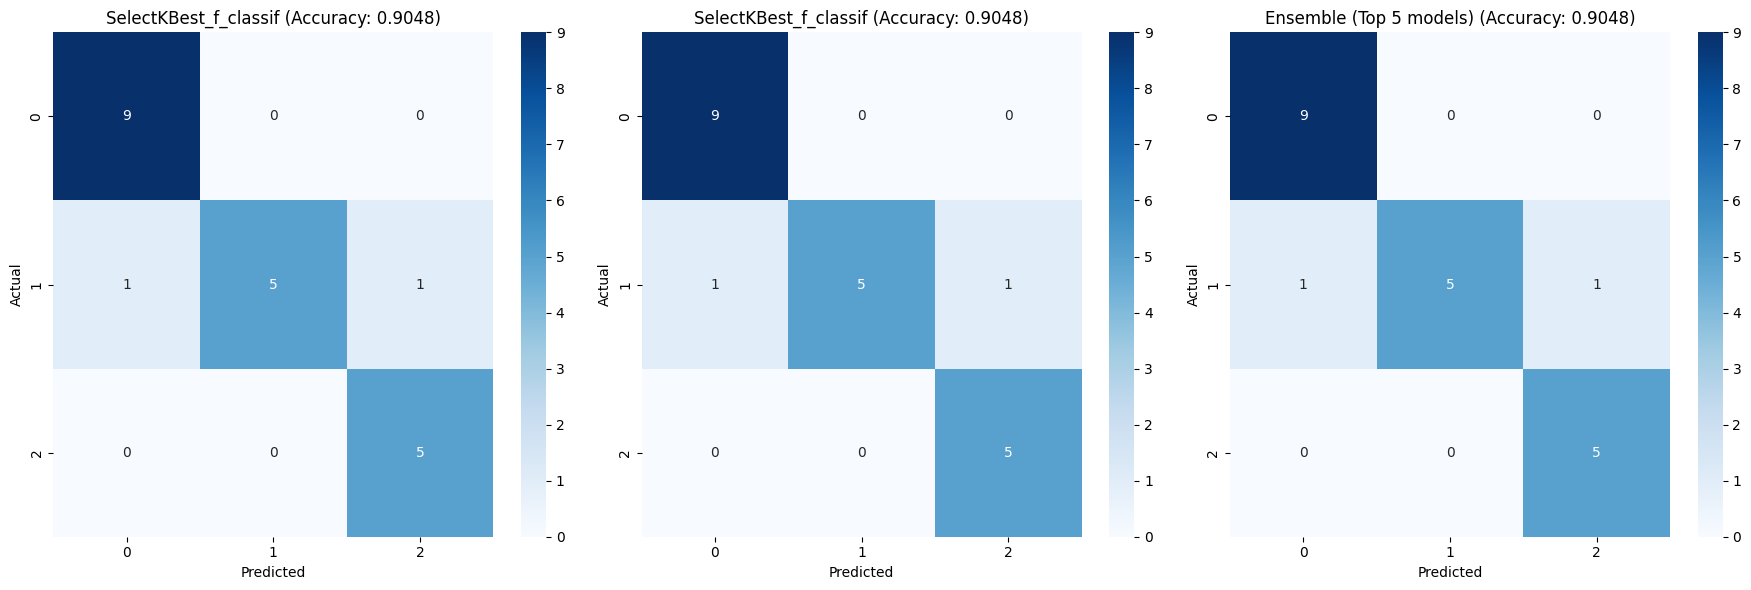

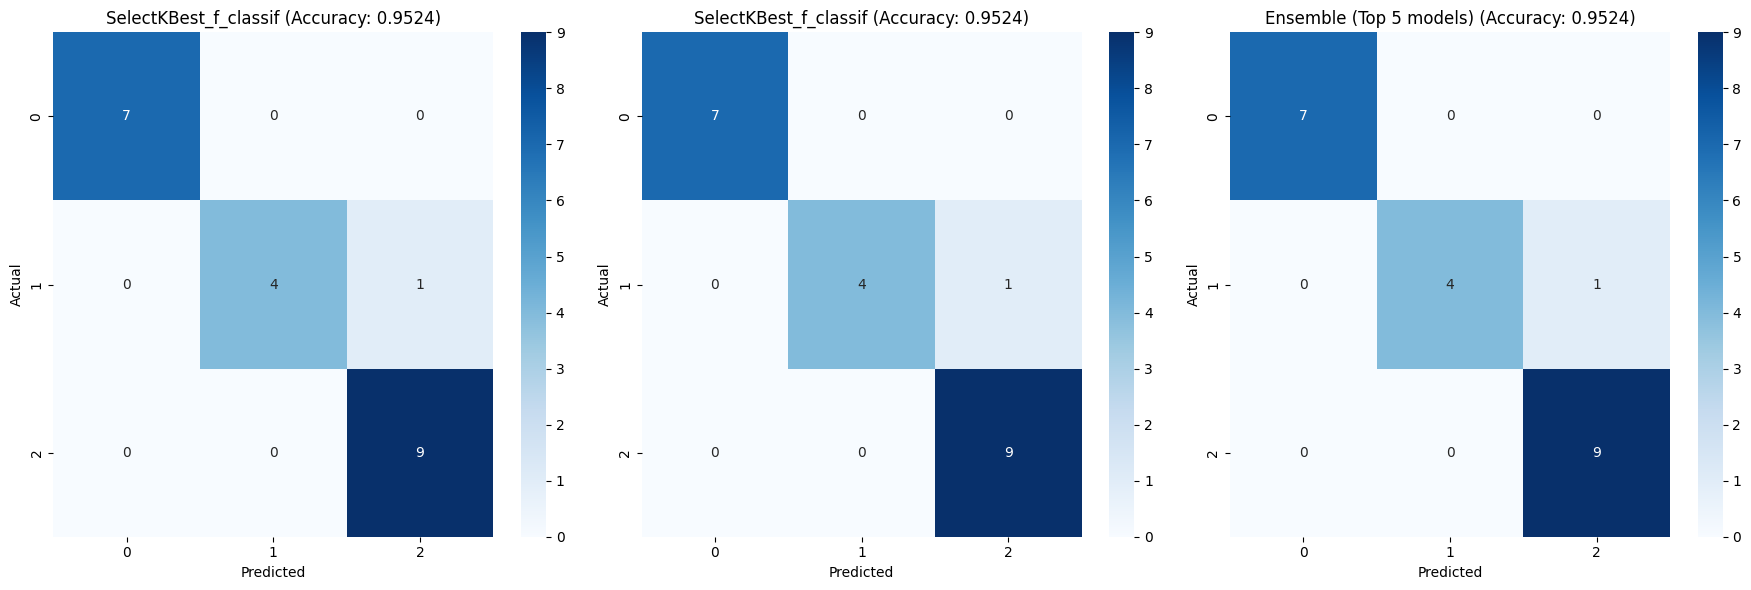

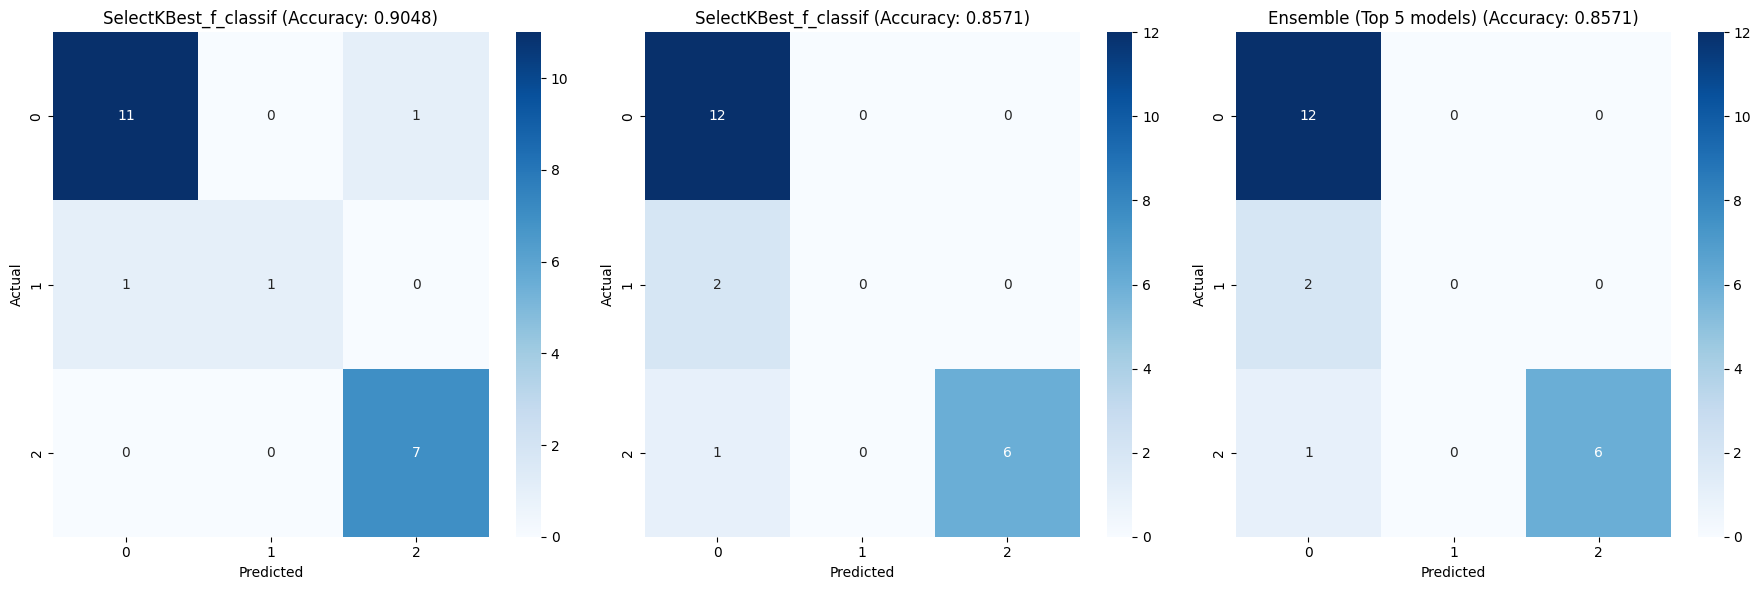

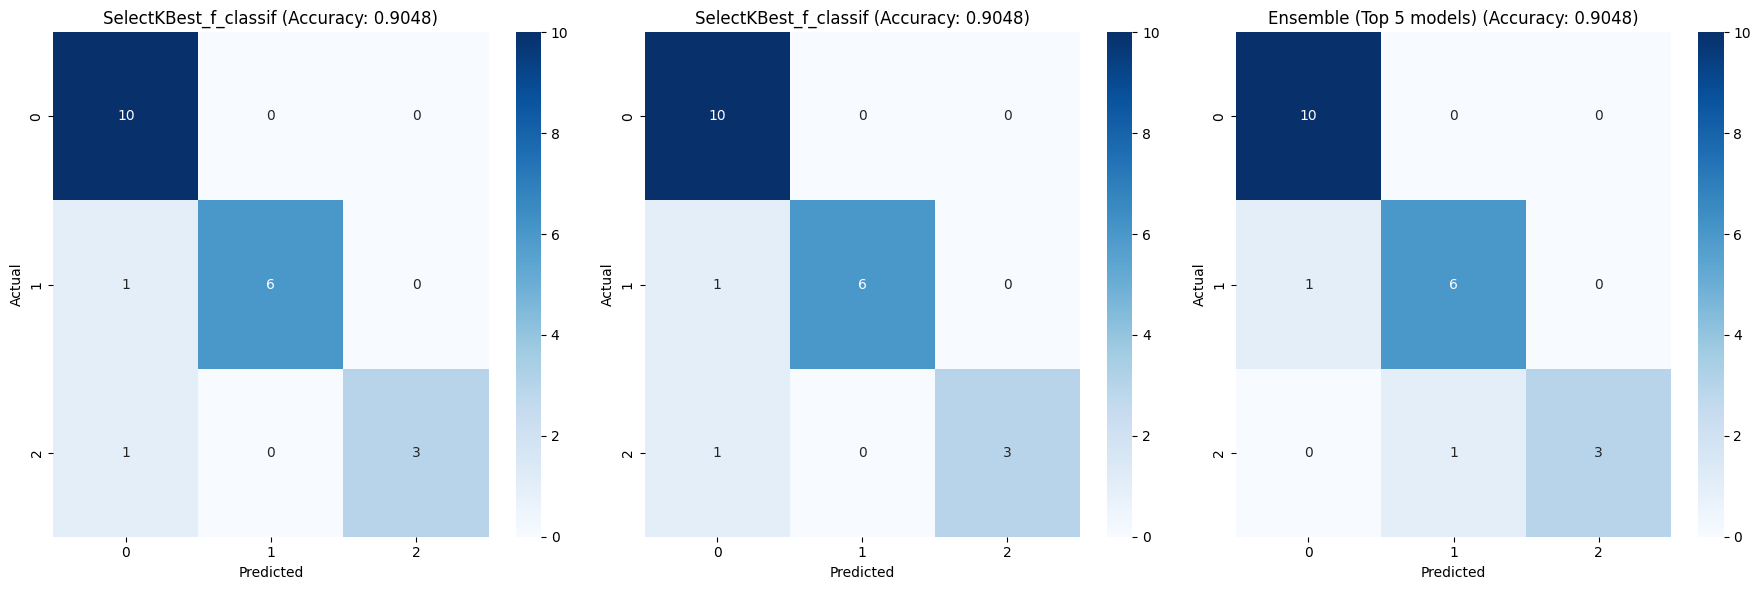

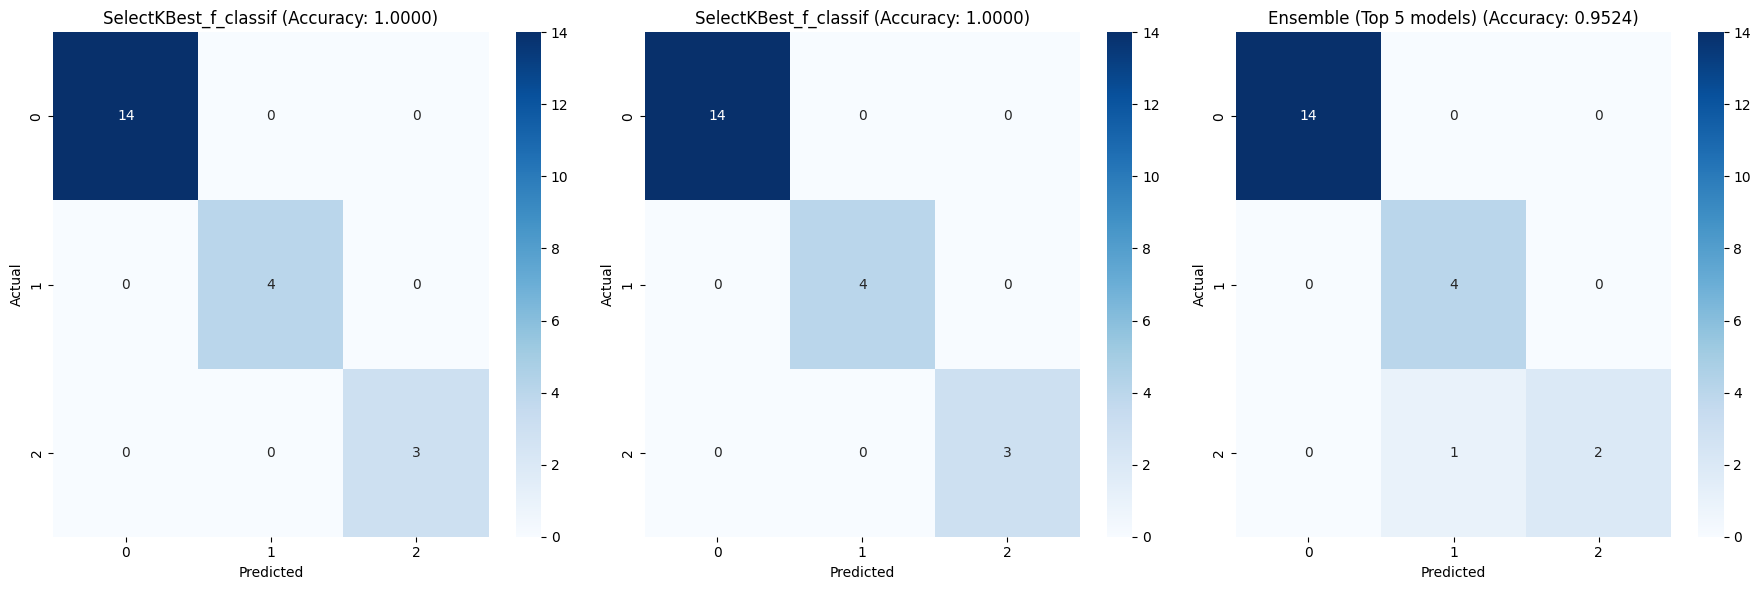

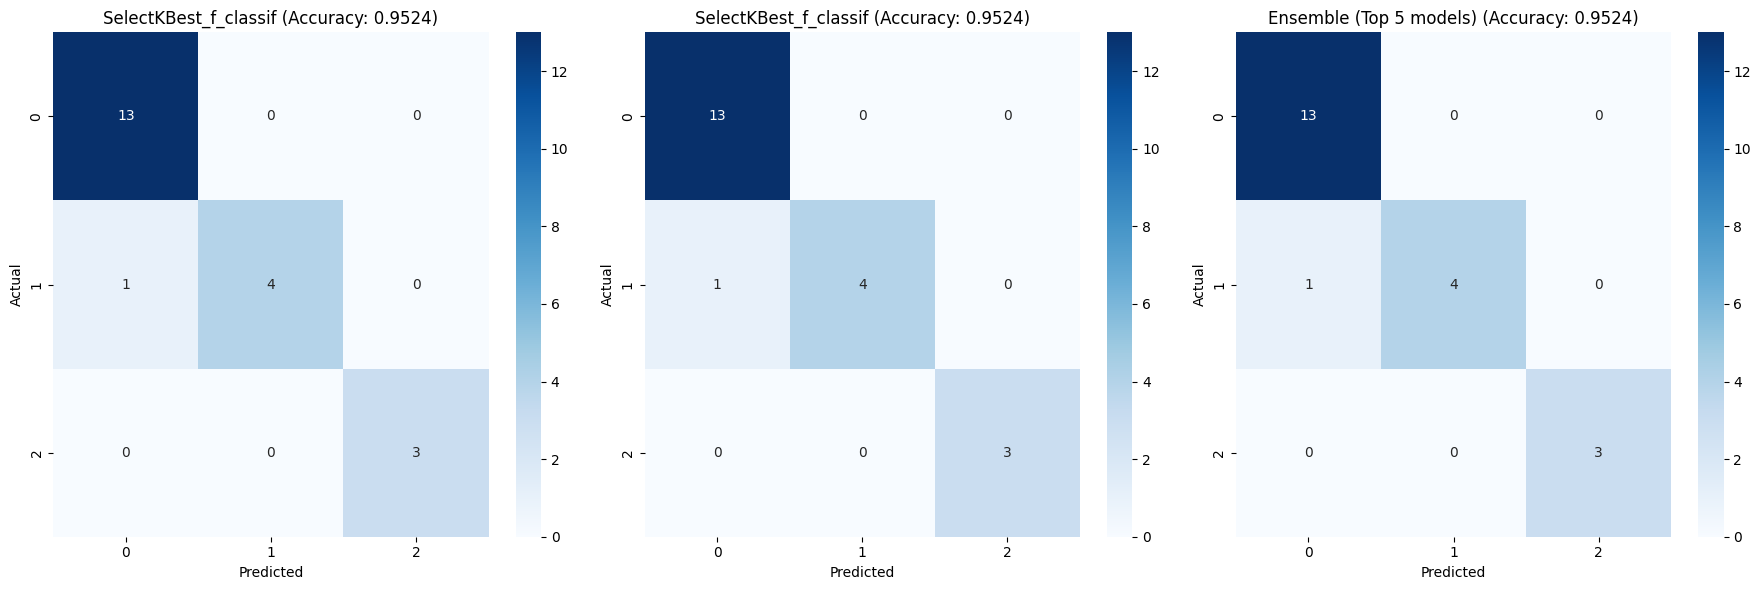

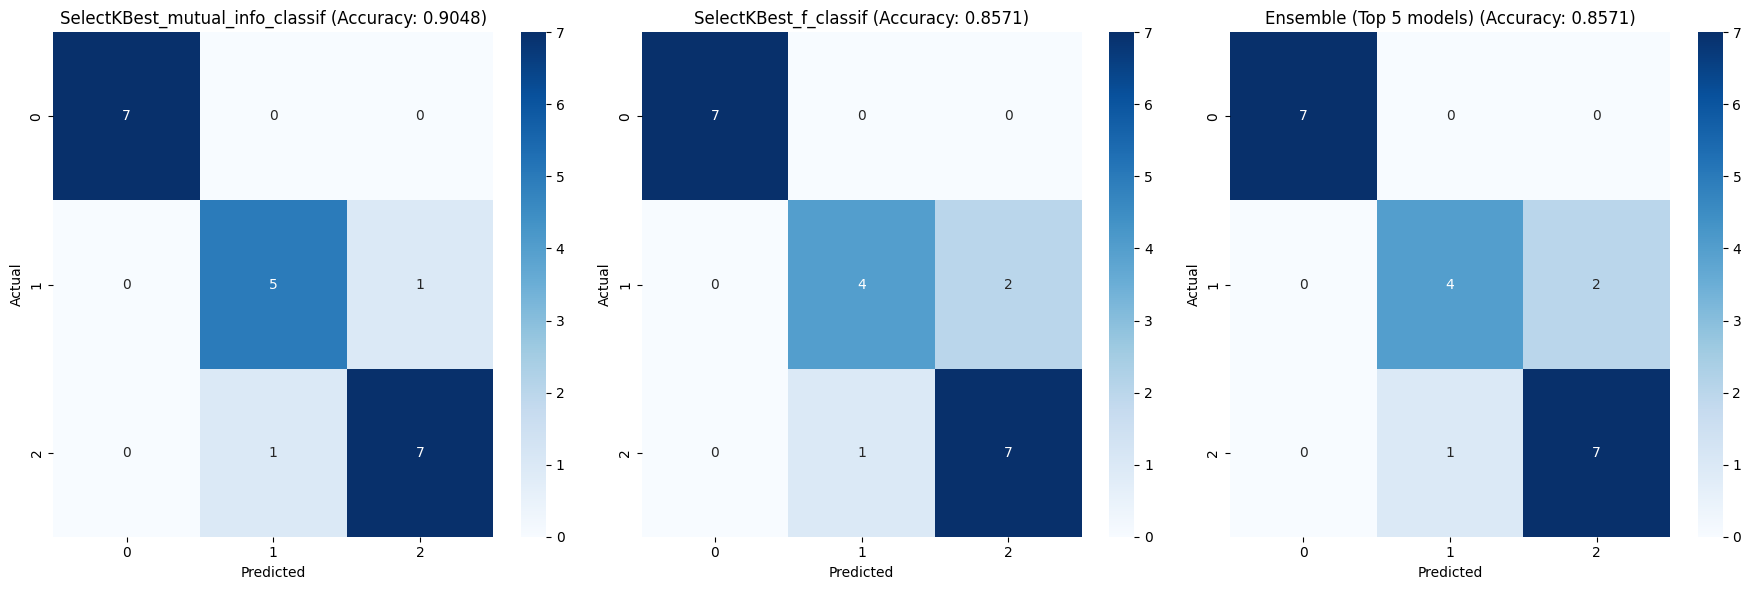

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings

warnings.filterwarnings("ignore")

# List of feature selection techniques
feature_selection_techniques = [
    "SelectKBest_f_classif",
    "SelectKBest_mutual_info_classif",
    "VarianceThreshold"
]

result_columns_list = ['PR', 'NR', 'SR', 'WS', 'SFST', 'PR_Benefit', 'NR_Benefit', 'SR_Benefit', 'WS_Benefit', 'SFST_Benefit']

for result_column in result_columns_list:
    # Load the test results from the CSV file
    test_results_df = pd.read_csv(f"test_results_{result_column}.csv")
    TITLE = result_column

    # Dictionary to store the best results for each feature selection technique
    best_results = []

    # Set to store all unique features
    all_features = set()

    # Iterate over each feature selection technique
    for technique in feature_selection_techniques:
        # Filter results for the current technique
        technique_results = test_results_df[test_results_df['Selection Method'] == technique]
        
        # Filter out models with more than 10 features
        technique_results = technique_results[technique_results['Number of Features'] <= 10]
        
        # Select the top three results based on highest accuracy
        top_three_rows = technique_results.nlargest(3, 'Accuracy')
        
        # Iterate over the top three rows
        for idx, best_row in top_three_rows.iterrows():
            # Extract actual and predicted values
            actual_values = list(map(int, best_row['Actual'].split(',')))
            predicted_values = list(map(int, best_row['Predicted'].split(',')))
            features = ast.literal_eval(best_row['Selected Features'])

            # Add the features to the set of all features
            all_features.update(features)
            
            # Store the best result
            best_results.append({
                'Selection Method': technique,
                'Accuracy': best_row['Accuracy'],
                'Actual': actual_values,
                'Predicted': predicted_values,
                'Number of Features': len(features),
                'Selected Features': features
            })

    # Sort the best results based on accuracy and select the top 5 for ensemble and top 2 for plotting
    best_results = sorted(best_results, key=lambda x: -x['Accuracy'])
    top_2_results = best_results[:2]
    top_5_results = best_results[:5]

    # Print a summary table of the top 2 models
    summary_table = pd.DataFrame(top_2_results)
    print(f"Summary of the top 2 models for {result_column}:")
    print(summary_table[['Selection Method', 'Accuracy']])

    # Generate and plot confusion matrices for the top 2 models
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes = axes.flatten()

    for idx, results in enumerate(top_2_results):
        cm = confusion_matrix(results['Actual'], results['Predicted'])
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[idx])
        axes[idx].set_title(f"{results['Selection Method']} (Accuracy: {results['Accuracy']:.4f})")
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

    # Calculate ensemble predictions
    ensemble_actual = top_5_results[0]['Actual']
    ensemble_predicted = np.round(np.mean(
        [results['Predicted'] for results in top_5_results],
        axis=0
    )).astype(int)

    # Calculate ensemble accuracy
    ensemble_accuracy = accuracy_score(ensemble_actual, ensemble_predicted)

    # Add the ensemble approach to the plot
    cm_ensemble = confusion_matrix(ensemble_actual, ensemble_predicted)
    sns.heatmap(cm_ensemble, annot=True, fmt="d", cmap="Blues", ax=axes[2])
    axes[2].set_title(f"Ensemble (Top 5 models) (Accuracy: {ensemble_accuracy:.4f})")
    axes[2].set_xlabel('Predicted')
    axes[2].set_ylabel('Actual')

    plt.tight_layout()
    plt.savefig(f"confusion_matrices_{TITLE}.png")
    #plt.show()

    # Print the combined unique features used in the top 5 models without quotes
    combined_features = set()
    for idx, result in enumerate(top_5_results):
        combined_features.update(result['Selected Features'])
    print(f"Combined unique features used in the top 5 models for {result_column}:")
    print(", ".join(sorted(combined_features)))
    
    print(f"Accuracy in the top 5 models for {result_column}:")
    print((ensemble_accuracy))
    '''
    # Find the method with the highest accuracy and lowest number of features
    best_method = min(best_results, key=lambda x: (-x['Accuracy'], x['Number of Features']))
    print(f"\nMethod with the highest accuracy and lowest number of features for {result_column}:")
    print(best_method)

    # Find the method with the highest accuracy proportionate to the number of features
    best_method_proportionate = max(best_results, key=lambda x: (x['Accuracy'] / x['Number of Features']))
    print(f"\nMethod with the highest accuracy proportionate to the number of features for {result_column}:")
    print(best_method_proportionate)
'''